In [3]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import QuantileTransformer  
from xgboost import XGBClassifier
%matplotlib inline

In [4]:
def import_raw_data(operating_system ='mac'):
    '''generate a dictionary of raw dataframes
    
    parameters
    -----------
    type of operating system used windows or mac
    default mac
    
    '''
    if operating_system == 'mac':
        base_file_path = r"/Users/{}/Desktop/data".format(os.getlogin())
    if operating_system == 'windows':
        base_file_path = r"C:\Users\{}\Desktop\data".format(os.getlogin())
    df_dict = dict()
    for file in os.listdir(base_file_path):
        if file.endswith('.csv'):
            df_dict[file.split('.')[0]] = pd.read_csv(os.path.join(base_file_path,file))
    return df_dict

# import data

In [5]:
df_dict = import_raw_data()
df = df_dict.get('winemag-data-130k-v2').copy()
temp_df = df_dict.get('temperature').copy()
country_iso = df_dict.get('country_iso_data').copy()
weather_month_v2 = df_dict.get('weather_country_month_v2').copy()
features = df_dict.get('data_test').copy()

In [6]:
df = df.iloc[:,:]
df.drop_duplicates(subset=['description','title'],inplace=True)
df.shape

(119988, 14)

<AxesSubplot:xlabel='test', ylabel='count'>

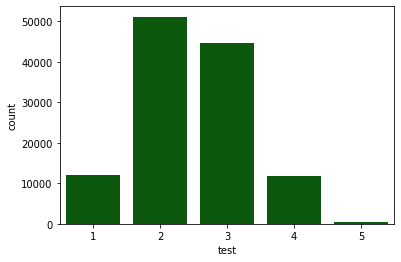

In [7]:
# changed from using original quantile list, big factor in driving results 
df['test'] = pd.cut(df['points'],bins=5,labels=[1,2,3,4,5])
df['test'].value_counts()
sns.countplot(x='test', color='darkgreen',
                  data=df)

**columns to remove**

description, designation & Twitter handle removed at this stage, explore later

In [8]:
COLUMN_DROP = ['Unnamed: 0','designation','region_2','taster_twitter_handle','points']
df.drop(columns=COLUMN_DROP,inplace=True)

## dealing with missing data


In [9]:
df.dropna(subset=['variety','province','country','taster_name','region_1'],inplace=True)

In [11]:
X = df.drop(columns=['test'])
y = df[['test']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2)

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22760 entries, 84256 to 69147
Data columns (total 9 columns):
country        22760 non-null object
description    22760 non-null object
price          21257 non-null float64
province       22760 non-null object
region_1       22760 non-null object
taster_name    22760 non-null object
title          22760 non-null object
variety        22760 non-null object
winery         22760 non-null object
dtypes: float64(1), object(8)
memory usage: 1.7+ MB


In [13]:
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train[['price']])
X_train['price'] = imp_median.transform(X_train[['price']])
X_test['price'] = imp_median.transform(X_test[['price']])

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# preprocessing  & Feature Engineering

extracting year from text and cleaing reuslt to produce valid year

In [14]:
## year 
count_year = X_train[X_train['title'].str.contains('\d',regex=True)].shape[0]
X_train['number_extract'] = X_train['title'].str.extract('(\d+)')
X_train['number_extract'] = np.where(len(X_train['number_extract'])<4 & len(X_train['number_extract'])<=5,np.nan,X_train['number_extract'])
X_train['number_extract'] = pd.to_numeric(X_train['number_extract'])
X_train['number_extract'] = np.where(
                    (X_train['number_extract']>=2021) | (X_train['number_extract']<=(2021-70)),
                    np.nan,
                    X_train['number_extract'])

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:5: 

In [15]:
count_year = X_test[X_test['title'].str.contains('\d',regex=True)].shape[0]
X_test['number_extract'] = X_test['title'].str.extract('(\d+)')
X_test['number_extract'] = np.where(len(X_test['number_extract'])<4 & len(X_test['number_extract'])<=5,np.nan,X_test['number_extract'])
X_test['number_extract'] = pd.to_numeric(X_test['number_extract'])
X_test['number_extract'] = np.where(
                    (X_test['number_extract']>=2021) | (X_test['number_extract']<=(2021-70)),
                    np.nan,
                    X_test['number_extract'])

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is t

adding simple imputer but may need to change

In [16]:
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train[['number_extract']])
X_train['number_extract'] = imp_median.transform(X_train[['number_extract']])
X_train['number_extract'] = pd.to_datetime(X_train['number_extract'],format='%Y').dt.year 
X_train.rename(columns={'number_extract':'year'},inplace=True)

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/pandas/core/frame.py:4025

In [17]:
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_test[['number_extract']])
X_test['number_extract'] = imp_median.transform(X_test[['number_extract']])
X_test['number_extract'] = pd.to_datetime(X_test['number_extract'],format='%Y').dt.year 
X_test.rename(columns={'number_extract':'year'},inplace=True)

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/pandas/core/frame.py:4025

calculating length of the name to work out whether name longer names and titles relate to better reviews

In [18]:
for col in ['title','taster_name']:
     X_train[f"{col}_length"] = X_train[col].apply(lambda x: len(x))

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
for col in ['title','taster_name']:
     X_test[f"{col}_length"] = X_test[col].apply(lambda x: len(x))

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
#TODO change labels to numbers
X_train['price_bin'] = pd.cut(X_train['price'],bins=15,labels=False)
X_train.drop(columns=['taster_name', 'title'],inplace=True)

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [21]:
X_test['price_bin'] = pd.cut(X_test['price'],bins=15,labels=False)
X_test.drop(columns=['taster_name', 'title'],inplace=True)

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Add Weather Data

additional feature related to average temperature for each year

In [22]:
weather_feature = X_train.set_index('country').join(country_iso.set_index('country'))
weather_iso_df = weather_month_v2.set_index('country').join(country_iso.set_index('country'))
weather_iso_df['year'] = pd.to_datetime(weather_iso_df['month']).dt.year
weather_iso_summary_df = weather_iso_df.groupby(['country_iso', 'year'], as_index=False).mean()

In [23]:
X_train = pd.merge(
              weather_feature, 
              weather_iso_summary_df,  
              how='left', 
              left_on=['country_iso','year'], 
              right_on=['country_iso','year']
             )

In [24]:
weather_feature = X_test.set_index('country').join(country_iso.set_index('country'))
weather_iso_df = weather_month_v2.set_index('country').join(country_iso.set_index('country'))
weather_iso_df['year'] = pd.to_datetime(weather_iso_df['month']).dt.year
weather_iso_summary_df = weather_iso_df.groupby(['country_iso', 'year'], as_index=False).mean()

In [25]:
X_test = pd.merge(
              weather_feature, 
              weather_iso_summary_df,  
              how='left', 
              left_on=['country_iso','year'], 
              right_on=['country_iso','year']
             )

In [26]:
imp_median = SimpleImputer(strategy='median')
imp_median.fit(X_train[['avg_temp']])
X_train['avg_temp'] = imp_median.transform(X_train[['avg_temp']])
X_test['avg_temp'] = imp_median.transform(X_test[['avg_temp']])

# NLP

In [27]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

In [28]:
def vocab_richness(text):
    tokens = word_tokenize(text)
    total_length = len(tokens)
    unique_words = set(tokens)
    unique_word_length = len(unique_words)
    return unique_word_length/total_length

X_train['vocab richness'] = X_train['description'].apply(vocab_richness)
X_test['vocab richness'] = X_test['description'].apply(vocab_richness)

## sentiment from text

In [29]:
import string 
punc = set(string.punctuation)

#loading stop_words
nltk.download('stopwords')

# creating a set of stop words
stop_words = set(stopwords.words('english'))

# combining the 2 sets with an "or" operator (i.e. "|")
all_stops = stop_words | punc

# loop to pre-process data
clean_desc_train =[]
for item in X_train['description'].to_list():
    tok_desc = word_tokenize(item)
    lower_data = [i.lower() for i in tok_desc]
    tok_desc_no_num = [i for i in lower_data if i.isalpha()]
    filtered_desc = [i for i in tok_desc_no_num if i not in all_stops]
    clean_desc_train.append(filtered_desc)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edwardburroughes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# # # Organizing the data in a new dataframe
clean_desc_untok = [' '.join(i) for i in clean_desc_train]
column_names = ['original_desc', 'untok_description']
data_tuple= list(zip(X_train['description'], clean_desc_untok))
desc_df = pd.DataFrame(data_tuple, columns=column_names)

In [31]:
nltk.download('movie_reviews')
tb = Blobber(analyzer=NaiveBayesAnalyzer())
blob = [tb(text) for text in desc_df['untok_description']]
sentiment_values = [text.sentiment for text in blob]

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/edwardburroughes/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [32]:
stats_train = pd.DataFrame(zip(*sentiment_values)).T
stats_train.columns = ['clf','pos','neg']

In [33]:
X_train = X_train.join(stats_train)

In [34]:
clean_desc_test =[]
for item in X_train['description'].to_list():
    tok_desc = word_tokenize(item)
    lower_data = [i.lower() for i in tok_desc]
    tok_desc_no_num = [i for i in lower_data if i.isalpha()]
    filtered_desc = [i for i in tok_desc_no_num if i not in all_stops]
    clean_desc_test.append(filtered_desc)

In [35]:
clean_desc_untok = [' '.join(i) for i in clean_desc_test]
column_names = ['original_desc', 'untok_description']
data_tuple= list(zip(X_test['description'], clean_desc_untok))
desc_df = pd.DataFrame(data_tuple, columns=column_names)
nltk.download('movie_reviews')
tb = Blobber(analyzer=NaiveBayesAnalyzer())
blob = [tb(text) for text in desc_df['untok_description']]
sentiment_values = [text.sentiment for text in blob]

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/edwardburroughes/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [36]:
stats_test = pd.DataFrame(zip(*sentiment_values)).T
stats_test.columns = ['clf','pos','neg']
X_test = X_test.join(stats_test)

move back onto original dataset

In [37]:
X_train.drop(columns='description',inplace=True)
X_test.drop(columns='description',inplace=True)

In [38]:
X_train.drop(columns='clf',inplace=True)
X_test.drop(columns='clf',inplace=True)
X_train[['pos','neg']] = X_train[['pos','neg']].astype(float)
X_test[['pos','neg']] = X_test[['pos','neg']].astype(float)

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = QuantileTransformer()
numeric_features = ['price','title_length','taster_name_length','avg_temp','year','vocab richness']
cat_features = ['province', 'region_1', 'variety', 'winery','price_bin', 'country_iso']
feature_year_encoder = ColumnTransformer([
            ('num_transformer', num_transformer,numeric_features),
            ('cat_transformer',cat_transformer,cat_features)
            ],n_jobs=None,remainder='drop')
feature_year_encoder.fit(X_train)
X_train = feature_year_encoder.transform(X_train)
X_test = feature_year_encoder.transform(X_test)

## Feature Selection
Feature selection defining best & worst features for one hot encoded categorical features

In [32]:
# from sklearn.metrics import f1_score

# def f1(model,X_test,y_test):
#     y_pred = model.predict(X_test)
#     score = f1_score(y_test,y_pred,average='weighted')
#     return score

# def create_dummies_ohe(X,cat_columns):
#     categorical_x = pd.get_dummies(X[cat_columns],prefix=['1','2','3','4','5'])
#     numeric_cols = list(set(X.columns)-set(cat_columns))
#     return pd.concat([X[numeric_cols],categorical_x], axis=1)

# def create_dummies_le(X,cat_columns):
#     le = preprocessing.LabelEncoder()
#     for col in cat_columns:
#         X[col] = le.fit_transform(X[col])
#     return X

Holdout method on the data

In [33]:
# #based on the features selected above
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import QuantileTransformer
# import warnings 
# warnings.simplefilter('ignore')
# numeric_features = ['price','title_length','taster_name_length','avg_temp','year','pos','neg']
# cat_features = ['province','variety','country_iso','price_bin','winery','region_1']

# def select_cat_data_threshold(X,feature_data,threshold_value,cat_features=cat_features):
#     dictionary_filter = {cat:feature_data.loc[(feature_data[cat]==True) & 
#                                               (feature_data['scores']<=threshold_value),'features']for cat in cat_features}
#     for cat,series in dictionary_filter.items():
#         X.loc[X[cat].isin(series),cat] = 'Other'
#     return (X,dictionary_filter)

test whether the model speed and F1 given the threshold defined above and PCA

In [ ]:
start = datetime.datetime.now()
rf_classifier = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
print(f1_score(y_test,y_pred,average='weighted'))
end = datetime.datetime.now()
print(end-start)

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SVMSMOTE
import datetime

oversample = BorderlineSMOTE(sampling_strategy='minority',k_neighbors=1,m_neighbors=20)
X_train_resample,y_train_resample = oversample.fit_resample(X_train,y_train)
# test = XGBClassifier(objective='multi:softmax')

model_map = {'knn':KNeighborsClassifier(),
            'rf':RandomForestClassifier,
            'nb':GaussianNB,
            'xgb':XGBClassifier,
            }

In [45]:
knn = KNeighborsClassifier()
knn_score = cross_val_score(knn,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted')
knn_score

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([0.5062194 , 0.36036397, 0.54266064])

In [46]:
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_score = cross_val_score(rf,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted')
rf_score

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params

array([0.5393538 , 0.36563915, 0.54720162])

In [47]:
nb = GaussianNB()
nb_score = cross_val_score(nb,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted')
nb_score

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 207, in fit
    X, y = self._validate_data(X, y)
  File "/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63

array([nan, nan, nan])

In [48]:
xgb = XGBClassifier(objective='multi:softmax',n_estimators=500)
xgb_score = cross_val_score(xgb,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted')
xgb_score

/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([0.5264309 , 0.35956128, 0.54779088])

In [262]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=500,n_jobs=-1),n_estimators=200,
                             algorithm = "SAMME.R", learning_rate = 0.5)
ada_clf_score = cross_val_score(ada_clf,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted')

In [ ]:
# svc = SVC()
# svc_score = cross_val_score(svc,X_train,y_train,cv=3,scoring='f1_weighted')
# svc_score

In [53]:
list_scores = [knn_score,rf_score,nb_score,xgb_score]
mean_score = [np.mean(i) for i in list_scores]
df_model_score = pd.DataFrame({'model_type':list(model_map.keys()),'mean_f1_score':mean_score})
df_model_score.sort_values('mean_f1_score',ascending=False,inplace=True)

In [54]:
df_model_score

,model_type,mean_f1_score
1,rf,0.484065
3,xgb,0.477928
0,knn,0.469748
2,nb,NaN


using F1-score as imbalanced dataset

## Smote

Using xgboost is almost is definitely better still very low lets amend the imbalances in the data


In [338]:
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,SVMSMOTE
from sklearn import neighbors
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
smote_pipeline = Pipeline(steps=steps)

In [355]:
# cross_val_score(test,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted')

In [356]:
rf.fit(X_train_resample, y_train_resample)
y_pred = rf.predict(X_test)

In [352]:
y_pred = rf.predict(X_test)

In [353]:
print(f1_score(y_test,y_pred,average='weighted'))

0.35582335571412443


In [ ]:
features = pd.DataFrame(zip(list(X_train.columns),list(rf.feature_importances_)))
features.columns = ['features','scores']

In [348]:
y_test
pd.Series(y_pred).unique()

array([2, 3, 1, 4])

smote perhaps a more focused sampling strategy is required for balancing the data

In [279]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([('o', oversample),
           ('xgb',XGBClassifier(n_estimators=500,n_jobs=-1))])
parameters = {'o__sampling_strategy':('minority','not majority','all'),
             'o__k_neighbors':[1,5],
             'o__m_neighbors':[1,20]}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                           verbose=5, scoring = "f1_weighted", 
                           refit=True, cv=5)
grid_search.fit(X_train_resample,y_train_resample)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('o',
                                        BorderlineSMOTE(k_neighbors=1,
                                                        m_neighbors=1,
                                                        sampling_strategy='minority')),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                               

In [280]:
grid_search.best_params_

{'o__k_neighbors': 1, 'o__m_neighbors': 20, 'o__sampling_strategy': 'all'}

## Hyperparameter Tuning XGBoost

In [56]:
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate":[0.05,0.1,0.15,0.2,0.25,0.3,0.35],
          "max_depth":[3,4,5,6,8,10,12,15,17],
          "min_child_weight":[1,3,5,7,9,11],
          "gamma":[0.0,0.1,0.3,0.4,0.5,0.6],
          "colsample_bytree":[0.3,0.4,0.5,0.7,0.8,0.9],
          "n_estimators":[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
         }
xgb_random_search = RandomizedSearchCV(xgb,
                                       param_distributions=params,
                                       cv=5,
                                       scoring='f1_weighted',
                                       verbose=3,
                                       n_iter = 10,
                                      random_state=1)

In [57]:
xgb_params = xgb_random_search.fit(X_train_resample,y_train_resample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.35, max_depth=3, min_child_weight=11, n_estimators=1600; total time= 3.7min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.35, max_depth=3, min_child_weight=11, n_estimators=1600; total time= 4.2min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.35, max_depth=3, min_child_weight=11, n_estimators=1600; total time= 3.6min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.35, max_depth=3, min_child_weight=11, n_estimators=1600; total time= 4.3min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.35, max_depth=3, min_child_weight=11, n_estimators=1600; total time= 4.2min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=600; total time= 1.6min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=600; total time= 2.1min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=600; total time= 1.8min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=600; total time= 2.1min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=600; total time= 1.8min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=1600; total time= 7.5min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=1600; total time= 9.8min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=1600; total time= 8.7min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=1600; total time= 9.6min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=1600; total time= 9.1min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.35, max_depth=5, min_child_weight=11, n_estimators=2000; total time= 6.9min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.35, max_depth=5, min_child_weight=11, n_estimators=2000; total time= 8.4min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.35, max_depth=5, min_child_weight=11, n_estimators=2000; total time= 7.5min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.35, max_depth=5, min_child_weight=11, n_estimators=2000; total time= 8.2min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.35, max_depth=5, min_child_weight=11, n_estimators=2000; total time= 7.5min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=2000; total time=15.6min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=2000; total time=20.6min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=2000; total time=19.7min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=2000; total time=19.1min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=2000; total time=17.9min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=9, n_estimators=800; total time= 6.5min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=9, n_estimators=800; total time= 8.2min


/Users/edwardburroughes/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


KeyboardInterrupt: 

In [58]:
print(f"model best score {xgb_params.best_score_}")
print(f"model best params {xgb_params.best_params_}")
params = xgb_params.best_params_

NameError: name 'xgb_params' is not defined

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [288]:
cross_val_score(xgb_params.best_estimator_,X_train_resample,y_train_resample,cv=3,scoring='f1_weighted').mean()

0.49018833666428474